In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, f1_score, precision_score,
    recall_score, roc_curve, auc, accuracy_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
import importlib
import funs
importlib.reload(funs) # prevents caching
from funs import find_best_threshold, plot_confusion_matrix

In [39]:
full_data = pd.read_csv("../../data/processed/full_data.csv")

In [ ]:
TARGET = 'is_fraud'
CORRELATION_TRESHOLD = 0

correlations = full_data.select_dtypes(include=[np.number]).corr()[TARGET].drop(TARGET)
selected_features = correlations[abs(correlations) >= CORRELATION_TRESHOLD].index.tolist() # easily adjustable threshold

X = full_data[selected_features]
y = full_data[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

XGBClassifier

In [41]:
params = {
    'objective':        'binary:logistic',
    'eval_metric':      'auc',
    'scale_pos_weight': 12.5,
    'learning_rate':    0.01,
    'n_estimators':     500,
    'max_depth':        6,
    'subsample':        0.8,
    'colsample_bytree': 0.8,
    'random_state':     42,
}

model = XGBClassifier(**params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

Finding optimal probability treshold

In [42]:
y_pred_prob = model.predict_proba(X_test)[:, 1]

best_thresh, best_f1 = find_best_threshold(y_test, y_pred_prob, metric='f1', verbose=False)
print(f"\nBest Threshold: {best_thresh:.2f} with F1 score: {best_f1:.4f}")

y_pred = (y_pred_prob >= best_thresh).astype(int)


Best Threshold: 0.64 with F1 score: 0.2565


Model evaluation

In [43]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


Confusion Matrix:
[[91560 22837]
 [ 5684  4919]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9415    0.8004    0.8652    114397
           1     0.1772    0.4639    0.2565     10603

    accuracy                         0.7718    125000
   macro avg     0.5594    0.6321    0.5609    125000
weighted avg     0.8767    0.7718    0.8136    125000

ROC AUC: 0.7188


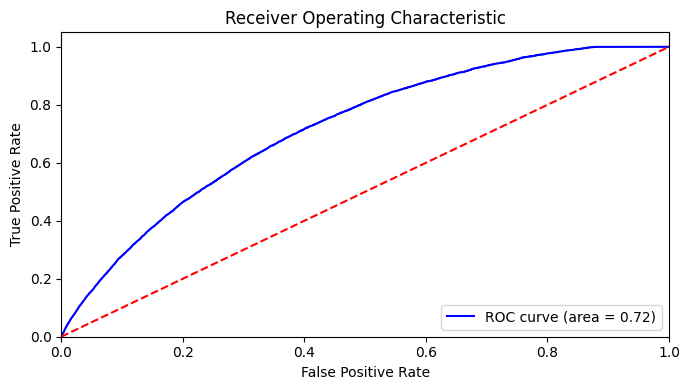

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

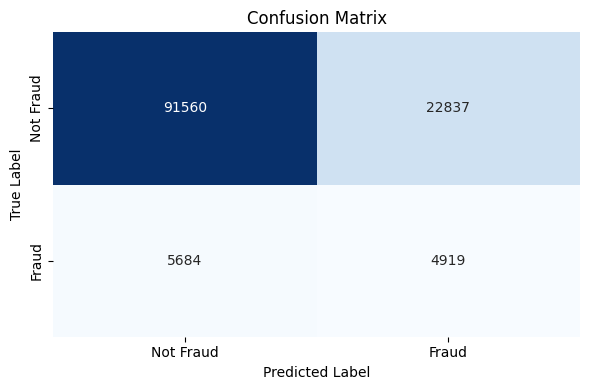

In [45]:
plot_confusion_matrix(y_test, y_pred)

Features importance

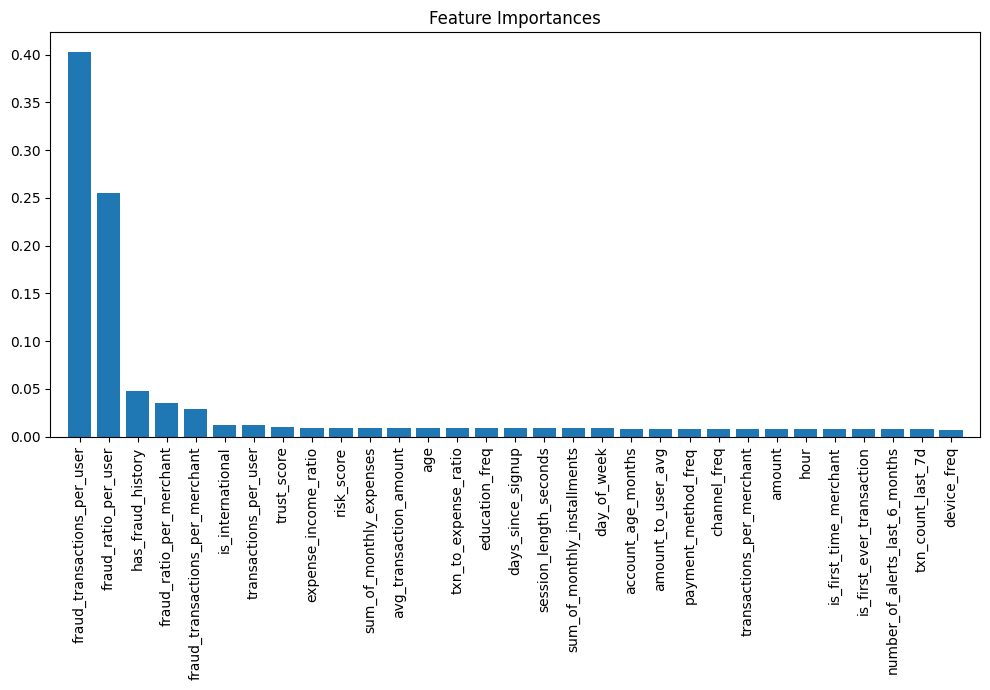

In [47]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 7))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(selected_features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()